# Visual Similarity Search

Implementation of a visual similarity search based on visual embeddings. The implementation is based on leveraging pre-trained embeddings from VGG16 (trained on Imagenet).
  
To do this, we will use a simple approach of using **embeddings**, vector representations of images.Once we have embeddings, searching simply becomes a matter of finding vectors close to our input vector.

The way we do this is by calculating the **cosine distance** between our image embedding, and embeddings for other images. Similar images will have similar embeddings, meaning a **low cosine distance between embeddings**.

## Setup

In [0]:
%%capture output
#!pip install keras
#!pip install tensorflow
#!pip install sklearn
#!pip install matplotlib
!pip install seaborn
!pip install annoy

## Dataset

Let's start by loading our dataset, which consists of a total of a **1000 images**, divided in **20 classes**  with 50 images for each.
    
This dataset can be found [here](http://vision.cs.uiuc.edu/pascal-sentences/). *Credit to Cyrus Rashtchian, Peter Young, Micah Hodosh, and Julia Hockenmaier.*

Image dataset must be of the format.
```
dataset/
|
|--- class_0/
|      |-------image_0
|      |-------image_1
|      ...
|
|      |-------image_n
|--- class_1/
|     ...
|  
|--- class_n/
```
Each class name should be one word in the english language, or multiple words separated by "_". In our example dataset for example, we rename the "diningtable" folder to "dining_table".

In [0]:
%%capture output
!pip install pyquery
!mkdir dataset

from urllib.parse import urljoin
from pyquery import PyQuery

import os
import requests

DATASET_DIR = 'dataset/'
PASCAL_DATASET_URL = 'http://vision.cs.uiuc.edu/pascal-sentences/'

def download_images():
    dom = PyQuery(PASCAL_DATASET_URL)
    for img in dom('img').items():
        img_src = img.attr['src']
        category, img_file_name = os.path.split(img_src)
        # make category directories
        output_dir = DATASET_DIR + category
        if not os.path.isdir(output_dir):
            os.mkdir(output_dir)
        # download image
        output = os.path.join(output_dir, img_file_name)
        print(output)
        if img_src.startswith('http'):
            img_url = img_src
        else:
            img_url = urljoin(PASCAL_DATASET_URL, img_src)
        if os.path.isfile(output):
            print("Already downloaded, Skipping: %s" % output)
            continue
        print("Downloading: %s" % output)
        with open(output, 'wb') as f:
            while True:
                result = requests.get(img_url)
                raw = result.content
                if result.status_code == 200:
                    f.write(raw)
                    break
                print("error occurred while fetching img")
                print("retry...")

download_images()

## Visualizing the data

Let's see what our data looks like, here is one example image from each class

We can see our labels are pretty **noisy**, many photos contain multiple categories, and the label is not always from the most prominent one.

Here is a list of our classes: aeroplane, bicycle, bird, boat, bottle, bus, car, cat, chair, cow, diningtable, dog, horse, motorbike, person, pottedplant, sheep, sofa, train, tvmonitor


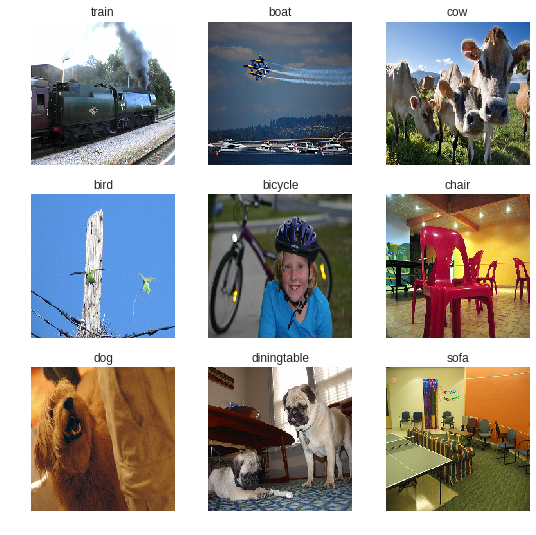

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input


def to_array(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    x_raw = image.img_to_array(img)
    return x_raw.astype(np.uint8)


def show_images(imgs, captions):
    N, R, C = 9, 3, 3
    plt.figure(figsize=(3*C, 3*R))
    for k in range(N):
        ax = plt.subplot(R, C, k+1)
        ax.imshow(imgs[k])
        plt.title('%s' %(captions[k]))
        plt.axis('off')
  
  
def show_top_n(n, res, search_by_img=True):
    top_n = np.stack([to_array(res[i][1]) for i in range(min(len(res), n))])
    captions = [res[i][2] for i in range(min(len(res), n))]
    if search_by_img:
        captions[0] = "OG"
    show_images(top_n, captions)


def load_images(folder):
    class_names = [fold for fold in os.listdir(folder) if ".DS" not in fold]
    image_list = []
    paths_list = []
    for cl in class_names:
        splits = cl.split("_")
        subfiles = [f for f in os.listdir(folder + "/" + cl) if ".DS" not in f]
        for subf in subfiles:
            full_path = os.path.join(folder, cl, subf)
            img = image.load_img(full_path, target_size=(224, 224))
            x_raw = image.img_to_array(img)
            x_expand = np.expand_dims(x_raw, axis=0)
            x = preprocess_input(x_expand)
            image_list.append(x)
            paths_list.append(full_path)
    img_data = np.array(image_list)
    img_data = np.rollaxis(img_data, 1, 0)
    img_data = img_data[0]
    return img_data, paths_list


images, image_paths = load_images('dataset')
all_labels = [fold.split("/")[1] for fold in image_paths]
print("Here is a list of our classes:", ', '.join('%s' % elt for elt in sorted(list(set(all_labels)))))

sample_images = [to_array(image_paths[1 + i * 50]) for i in range(20)]
captions = [all_labels[1 + i * 50] for i in range(20)]
show_images(sample_images[:9], captions[:9])

## Indexing the images

We are now going to load a model that was **pre-trained** on a large data set (imagenet), and is freely available online. We use this model to generate **embeddings** for our images.

Once we've used the model to generate image features, we can then **store them to disk** and re-use them without needing to do inference again! This is one of the reason that embeddings are so popular in practical applications, as they allow for huge efficiency gains.

Our model is simply VGG16 without the last layer (softmax)

What do we mean by generating embeddings? Well we just use our pre-trained model up to the penultimate layer, and store the value of the activations. In this case, each image is now represented by a sparse vector of size 4096.

Now that we have the features, we will build a fast index to search through them using Annoy.

In [21]:
import os
import json
import time
import h5py
import numpy as np

from annoy import AnnoyIndex
from keras import optimizers
from keras.layers import Dense, BatchNormalization, Activation, Dropout
from keras.losses import cosine_proximity
from keras.preprocessing import image
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input


def load_headless_pretrained_model():
    """
    Loads the pretrained version of VGG with the last layer cut off
    :return: pre-trained headless VGG16 Keras Model
    """
    pretrained_vgg16 = VGG16(weights='imagenet', include_top=True)
    model = Model(inputs=pretrained_vgg16.input, outputs=pretrained_vgg16.get_layer('fc2').output)
    return model

  
def generate_features(image_paths, model):
    """
    Takes in an array of image paths, and a trained model.
    Returns the activations of the last layer for each image
    :param image_paths: array of image paths
    :param model: pre-trained model
    :return: array of last-layer activations, and mapping from array_index to file_path
    """
    start = time.time()
    images = np.zeros(shape=(len(image_paths), 224, 224, 3))
    file_mapping = {i: f for i, f in enumerate(image_paths)}
    # We load all our dataset in memory because it is relatively small
    for i, f in enumerate(image_paths):
        img = image.load_img(f, target_size=(224, 224))
        x_raw = image.img_to_array(img)
        x_expand = np.expand_dims(x_raw, axis=0)
        images[i, :, :, :] = x_expand
    print("%s images loaded" % len(images))
    inputs = preprocess_input(images)
    print("Images preprocessed")
    images_features = model.predict(inputs)
    end = time.time()
    print("Inference done, %s Generation time" % (end - start))
    return images_features, file_mapping


def save_features(features_filename, features, mapping_filename, file_mapping):
    """
    Save feature array and file_item mapping to disk
    :param features_filename: path to save features to
    :param features: array of features
    :param mapping_filename: path to save mapping to
    :param file_mapping: mapping from array_index to file_path/plaintext_word
    """
    np.save('%s.npy' % features_filename, features)
    with open('%s.json' % mapping_filename, 'w') as index_file:
        json.dump(file_mapping, index_file)
    logger.info("Weights saved")


def load_features(features_filename, mapping_filename):
    """
    Loads features and file_item mapping from disk
    :param features_filename: path to load features from
    :param mapping_filename: path to load mapping from
    :return: feature array and file_item mapping to disk
    """
    images_features = np.load('%s.npy' % features_filename)
    with open('%s.json' % mapping_filename) as f:
        index_str = json.load(f)
        file_index = {int(k): str(v) for k, v in index_str.items()}
    return images_features, file_index

  
def index_features(features, n_trees=1000, dims=4096, is_dict=False):
    """
    Use Annoy to index our features to be able to query them rapidly
    :param features: array of item features
    :param n_trees: number of trees to use for Annoy. Higher is more precise but slower.
    :param dims: dimension of our features
    :return: an Annoy tree of indexed features
    """
    feature_index = AnnoyIndex(dims, metric='angular')
    for i, row in enumerate(features):
        vec = row
        if is_dict:
            vec = features[row]
        feature_index.add_item(i, vec)
    feature_index.build(n_trees)
    return feature_index


def search_index_by_key(key, feature_index, item_mapping, top_n=10):
    """
    Search an Annoy index by key, return n nearest items
    :param key: the index of our item in our array of features
    :param feature_index: an Annoy tree of indexed features
    :param item_mapping: mapping from indices to paths/names
    :param top_n: how many items to return
    :return: an array of [index, item, distance] of size top_n
    """
    distances = feature_index.get_nns_by_item(key, top_n, include_distances=True)
    return [[a, item_mapping[a], distances[1][i]] for i, a in enumerate(distances[0])]


def search_index_by_value(vector, feature_index, item_mapping, top_n=10):
    """
    Search an Annoy index by value, return n nearest items
    :param vector: the index of our item in our array of features
    :param feature_index: an Annoy tree of indexed features
    :param item_mapping: mapping from indices to paths/names
    :param top_n: how many items to return
    :return: an array of [index, item, distance] of size top_n
    """
    distances = feature_index.get_nns_by_vector(vector, top_n, include_distances=True)
    return [[a, item_mapping[a], distances[1][i]] for i, a in enumerate(distances[0])]


model = load_headless_pretrained_model()
images_features, file_index = generate_features(image_paths, model)
image_index = index_features(images_features)

ResourceExhaustedError: ignored

## Using our embeddings to search through images

We can now simply take in an image, get its **embedding** (saved to disk), and look in our fast index to find **similar embeddings, and thus similar images**.
    
This is especially useful, since image labels are often noisy, so there is more to an image than it's label. Labeling images as unique categories is quite limiting, which is why we hope to use more nuanced representations.

In [0]:
import random

search_key = random.randint(0, 999)
print("Searching for index `%s`, file `%s`" % (search_key, image_paths[search_key]))

results = search_index_by_key(search_key, image_index, file_index)
print('\n'.join('- `%s`' % elt for elt in results))
show_top_n(9, results)

This approach perform wells to find similar images in general, but some times we are only interested
in **part of the image**. For example, given an image of a cat and a bottle, we might be only interested in similar cats, not similar bottles. A common approach is to use an **object detection** model first, detect our cat, and do image search on a cropped version of the original image.

## Using pre-trained models for image search

In [0]:
import glob
import numpy as np
from keras.engine.saving import load_model
from utils import load_paired_img_wrd


def index_images(folder, features_path, mapping_path, model):
    _, _, paths = load_paired_img_wrd(folder, [], use_word_vectors=False)
    images_features, file_index = generate_features(paths, model)
    save_features(features_path, images_features, mapping_path, file_index)
    return images_features, file_index


# This is an inefficient implimentation for the proof of context
def get_index(input_image, file_mapping):
    for index, file in file_mapping.items():
        if file == input_image:
            return index
    raise ValueError("Image %s not indexed" % input_image)

## Search for a similar image to an input image

You need to index your images first, then you can search through your images.


In [0]:
features_path = 'imagenet_features'
index_folder = 'dataset'
file_mapping = 'index'

loaded_model = load_headless_pretrained_model()
features, index = index_images(index_folder, features_path, file_mapping, loaded_model)
print("Indexed %s images" % len(features))

images_features, file_index = load_features(features_path, file_mapping)
image_index = index_features(images_features, dims=4096)

dataset/cow/2008_002278.jpg
- `[140, 'dataset/cow/2008_002278.jpg', 0.0]`
- `[103, 'dataset/cow/2008_005010.jpg', 0.7665741443634033]`
- `[127, 'dataset/cow/2008_007025.jpg', 0.7741913795471191]`
- `[115, 'dataset/cow/2008_007031.jpg', 0.8207802176475525]`
- `[134, 'dataset/cow/2008_007596.jpg', 0.8451181054115295]`
- `[120, 'dataset/cow/2008_008482.jpg', 0.8872503638267517]`
- `[133, 'dataset/cow/2008_008617.jpg', 0.894599199295044]`
- `[135, 'dataset/cow/2008_003094.jpg', 0.9038317799568176]`
- `[117, 'dataset/cow/2008_006904.jpg', 0.920072615146637]`
- `[109, 'dataset/cow/2008_008428.jpg', 0.9623794555664062]`


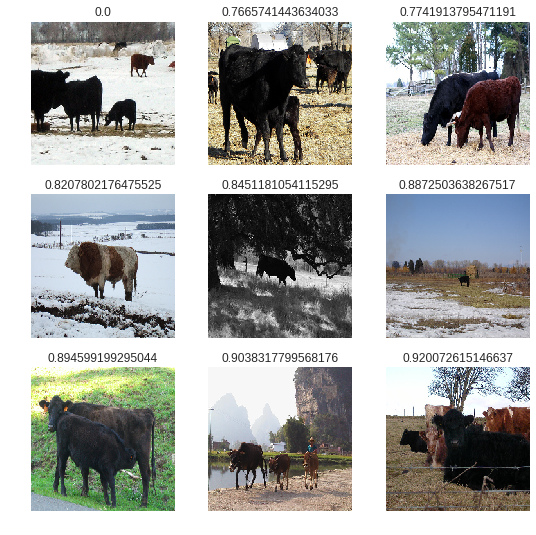

In [27]:
input_image = np.random.choice(glob.glob('dataset/*/*.jpg'))
search_key = get_index(input_image, file_index)
results = search_index_by_key(search_key, image_index, file_index)
print(input_image)
#results = search_index_by_value(embeddings, image_index, file_index)
print('\n'.join('- `%s`' % elt for elt in results))
show_top_n(9, results, search_by_img=False)

## T-Distributed Stochastic Neighbouring Entities (t-SNE)

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a technique for dimensionality reduction and is particularly well suited for the visualization of high-dimensional datasets. Contrary to PCA it is not a mathematical technique but a probablistic one. 

In [28]:
import time

from sklearn.manifold import TSNE

time_start = time.time()
#tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(images_features)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 17.91818404197693 seconds


From this plot we can clearly see how all the samples are nicely spaced apart and grouped together with their respective digits. This could be an amazing starting point to then use a clustering algorithm and try to identify the clusters or to actually use these two dimensions as input to another algorithm (e.g., something like a Neural Network).

So we have explored using various dimensionality reduction techniques to visualise high-dimensional data using a two-dimensional scatter plot. We have not gone into the actual mathematics involved but instead relied on the Scikit-Learn implementations of all algorithms.

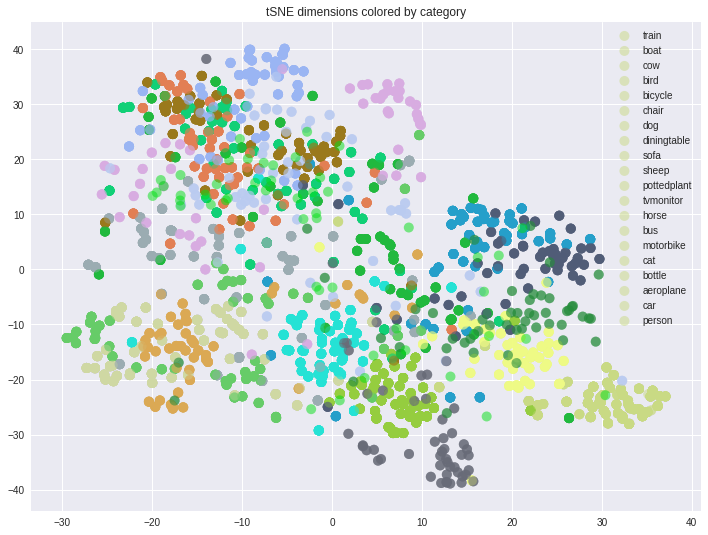

In [29]:
import numpy as np
import matplotlib.pyplot as plt

N = len(tsne_results)
x_tsne = tsne_results[:,0]
y_tsne = tsne_results[:,1]
lbls = [file_index[k].split('/')[1] for k in range(N)]

colors = np.random.rand(20, 3)
labels = [file_index[k*50].split('/')[1] for k in range(20)]

color = np.array([colors[int(k / 50)] for k in range(N)])

plt.figure(figsize=(12, 9))
plt.title('tSNE dimensions colored by category')
for k in range(20):
    x = x_tsne[k:(k+1)*50]
    y = y_tsne[k:(k+1)*50]
    c = color[k:(k+1)*50]
    plt.scatter(x, y, c=c, s=100, label=labels[k], alpha=0.5, edgecolors='none')
plt.legend()
plt.show()

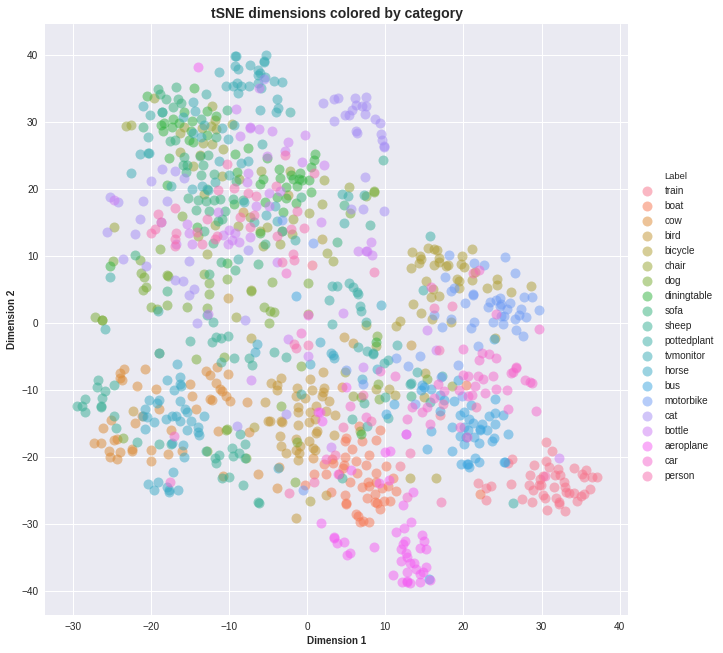

In [30]:
import pandas as pd
import seaborn as sns

data = pd.DataFrame({'x_tsne': x_tsne, 'y_tsne': y_tsne, 'Label': lbls})

sns.lmplot(x='x_tsne', y='y_tsne', data=data, fit_reg=False, legend=True, size=9, hue='Label', scatter_kws={'s': 100, 'alpha': .5})
plt.title('tSNE dimensions colored by category', weight='bold').set_fontsize('14')
plt.xlabel('Dimension 1', weight='bold').set_fontsize('10')
plt.ylabel('Dimension 2', weight='bold').set_fontsize('10')